In [2]:
!pip install pandas

     |████████████████████████████████| 11.5 MB 8.6 MB/s eta 0:00:01


In [5]:
!pip install seaborn

     |████████████████████████████████| 292 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 58.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 34.2 MB/s eta 0:00:01


In [8]:
import pandas as pd
import os, json
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

In [7]:
img_size = (512,512)
num_classes = 1

In [ ]:
# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
#     union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
#     return tf.reduce_mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [80]:
import keras.backend as K
import math
# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#     union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
#     return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice_coeff = tf.reduce_mean( (2. * intersection + smooth) / (union + smooth), axis=0)
    if tf.math.is_nan(dice_coeff):
        print("Dice coeff nan for {}".format(y_true))
    return dice_coeff

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [81]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    outputs = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(x)
    
    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
mirrored_strategy = tf.distribute.MirroredStrategy()
# Build model
with mirrored_strategy.scope():
    model = get_model(img_size, num_classes)
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=['binary_crossentropy'], metrics=[dice_coef])
#model = get_model(img_size, num_classes)
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
_______________________________________________

### Build the data generator

In [9]:
# will keep the test set for hold out, we need to get the val set generated from train files so that we can shuffle well
train_images_path =  '/data/all/train/images'
file_list = os.listdir(train_images_path)
print(len(file_list))

208836


In [10]:
val_ratio = 0.2
SEED = 2021
random.seed(SEED)
#file_list = [i for i in range(len(patient_list))]
num_files = len(file_list)
idxs = np.arange(num_files)
random.shuffle(idxs)
train_image_files = np.array(file_list)[idxs][:int(num_files*(1-val_ratio))]
train_mask_files = [fn.replace('img','mask') for fn in train_image_files]

val_image_files = np.array(file_list)[idxs][int(num_files*(1-val_ratio)):]
val_mask_files = [fn.replace('img','mask') for fn in val_image_files]

### Use only a subset of the files

In [11]:
# use only a subset of the images, to test the model first
num_tr_files = len(train_image_files)
num_val_files = len(val_image_files)
frac = 0.2
train_image_files = train_image_files[:int(num_tr_files*frac)]
val_image_files = val_image_files[:int(num_val_files*frac)]

In [12]:
len(val_image_files)

8353

In [13]:
print(train_image_files[:5])
print(train_mask_files[:5])

['img_LIDC-IDRI-0799_153.npz' 'img_LIDC-IDRI-0492_1.npz'
 'img_LIDC-IDRI-0826_290.npz' 'img_LIDC-IDRI-0386_292.npz'
 'img_LIDC-IDRI-0089_125.npz']
['mask_LIDC-IDRI-0799_153.npz', 'mask_LIDC-IDRI-0492_1.npz', 'mask_LIDC-IDRI-0826_290.npz', 'mask_LIDC-IDRI-0386_292.npz', 'mask_LIDC-IDRI-0089_125.npz']


In [15]:
print(val_image_files[:5])
print(val_mask_files[:5])

['img_LIDC-IDRI-0521_123.npz' 'img_LIDC-IDRI-0647_67.npz'
 'img_LIDC-IDRI-0350_103.npz' 'img_LIDC-IDRI-0301_266.npz'
 'img_LIDC-IDRI-0797_153.npz']
['mask_LIDC-IDRI-0521_123.npz', 'mask_LIDC-IDRI-0647_67.npz', 'mask_LIDC-IDRI-0350_103.npz', 'mask_LIDC-IDRI-0301_266.npz', 'mask_LIDC-IDRI-0797_153.npz']


In [16]:
print("Number of train and val samples are {} and {} respectively".format(len(train_image_files), len(val_image_files)))

Number of train and val samples are 33413 and 8353 respectively


In [19]:
from PIL import Image

In [20]:
def load_image(image_file, root_dir):
    compr_files = np.load(root_dir + "/" + image_file)
    img_data = compr_files['arr_0']
    #rescale the image, rescale to 0 and 1,  note: you cannot display the PIL image in notebook because the values are not in 0-255 range, you can instead
    # convert them to numpy arrays and use matplotlib to show the image
    rescaled = (255.0 / img_data.max() * (img_data - img_data.min())).astype(np.uint8)/255.0
    return Image.fromarray(rescaled)

In [21]:
# def load_mask(image_file, root_dir):
#     compr_files = np.load(root_dir + "/" + image_file)
#     img_data = compr_files['arr_0']
#     #rescale the image
#     rescaled = (255.0 / img_data.max() * (img_data - img_data.min())).astype(np.uint8)
#     return Image.fromarray(rescaled)
def load_mask(image_file, root_dir):
    compr_files = np.load(root_dir + "/" + image_file)
    img_data = compr_files['arr_0']
    #rescale the image
    #rescaled = (255.0 / img_data.max() * (img_data - img_data.min())).astype(np.uint8)/255.0
    img_data = img_data.astype('float32')
    return Image.fromarray(img_data)

In [22]:
val_mask_files

['mask_LIDC-IDRI-0521_123.npz',
 'mask_LIDC-IDRI-0647_67.npz',
 'mask_LIDC-IDRI-0350_103.npz',
 'mask_LIDC-IDRI-0301_266.npz',
 'mask_LIDC-IDRI-0797_153.npz',
 'mask_LIDC-IDRI-0558_12.npz',
 'mask_LIDC-IDRI-0873_59.npz',
 'mask_LIDC-IDRI-0692_79.npz',
 'mask_LIDC-IDRI-0168_148.npz',
 'mask_LIDC-IDRI-0375_261.npz',
 'mask_LIDC-IDRI-0793_292.npz',
 'mask_LIDC-IDRI-0373_408.npz',
 'mask_LIDC-IDRI-0408_255.npz',
 'mask_LIDC-IDRI-0844_225.npz',
 'mask_LIDC-IDRI-0564_191.npz',
 'mask_LIDC-IDRI-0755_82.npz',
 'mask_LIDC-IDRI-0558_283.npz',
 'mask_LIDC-IDRI-0552_22.npz',
 'mask_LIDC-IDRI-0614_32.npz',
 'mask_LIDC-IDRI-0480_68.npz',
 'mask_LIDC-IDRI-0382_6.npz',
 'mask_LIDC-IDRI-0943_412.npz',
 'mask_LIDC-IDRI-0778_35.npz',
 'mask_LIDC-IDRI-0356_95.npz',
 'mask_LIDC-IDRI-0841_72.npz',
 'mask_LIDC-IDRI-0309_47.npz',
 'mask_LIDC-IDRI-0684_381.npz',
 'mask_LIDC-IDRI-0409_210.npz',
 'mask_LIDC-IDRI-0408_225.npz',
 'mask_LIDC-IDRI-0437_191.npz',
 'mask_LIDC-IDRI-0681_210.npz',
 'mask_LIDC-IDRI-0728_

In [15]:
#check it for this patient
sample_patient_id = 'LIDC-IDRI-0648'#'LIDC-IDRI-0636'#'LIDC-IDRI-0532'#'LIDC-IDRI-0414' #'LIDC-IDRI-0419' #'LIDC-IDRI-0086'
arr1 = np.array([fl.find(sample_patient_id) for fl in val_mask_files])
sel_ids = np.where(arr1 >= 0)
sel_masks = np.array(val_mask_files)[sel_ids]

In [17]:
root_dir = '/data/train/masks/'
#arr = load_mask(sel_masks[0], root_dir)
[(np.max(load_mask(sel_mask, root_dir)), sel_mask) for sel_mask in sel_masks]

[(0, 'mask_LIDC-IDRI-0648_37.npz'),
 (0, 'mask_LIDC-IDRI-0648_383.npz'),
 (0, 'mask_LIDC-IDRI-0648_553.npz'),
 (0, 'mask_LIDC-IDRI-0648_628.npz'),
 (0, 'mask_LIDC-IDRI-0648_532.npz'),
 (0, 'mask_LIDC-IDRI-0648_21.npz'),
 (0, 'mask_LIDC-IDRI-0648_185.npz'),
 (0, 'mask_LIDC-IDRI-0648_673.npz'),
 (1, 'mask_LIDC-IDRI-0648_501.npz'),
 (0, 'mask_LIDC-IDRI-0648_283.npz'),
 (0, 'mask_LIDC-IDRI-0648_729.npz'),
 (0, 'mask_LIDC-IDRI-0648_588.npz'),
 (0, 'mask_LIDC-IDRI-0648_239.npz'),
 (0, 'mask_LIDC-IDRI-0648_255.npz'),
 (0, 'mask_LIDC-IDRI-0648_195.npz'),
 (0, 'mask_LIDC-IDRI-0648_34.npz'),
 (0, 'mask_LIDC-IDRI-0648_99.npz'),
 (0, 'mask_LIDC-IDRI-0648_579.npz'),
 (0, 'mask_LIDC-IDRI-0648_102.npz'),
 (0, 'mask_LIDC-IDRI-0648_300.npz'),
 (0, 'mask_LIDC-IDRI-0648_157.npz'),
 (0, 'mask_LIDC-IDRI-0648_630.npz'),
 (0, 'mask_LIDC-IDRI-0648_319.npz'),
 (0, 'mask_LIDC-IDRI-0648_398.npz'),
 (0, 'mask_LIDC-IDRI-0648_717.npz'),
 (0, 'mask_LIDC-IDRI-0648_253.npz'),
 (0, 'mask_LIDC-IDRI-0648_614.npz'),
 (0, 

In [90]:
img = load_image('img_LIDC-IDRI-0648_496.npz', '/data/train/images/')
mask = load_mask('mask_LIDC-IDRI-0648_496.npz', '/data/train/masks/')

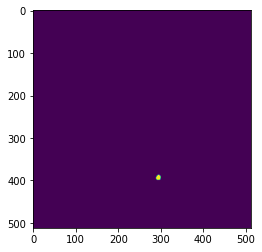

In [91]:
plt.imshow(np.array(mask))

In [92]:
np.unique(np.array(mask))

array([0., 1.], dtype=float32)

In [19]:
# type(img)

In [20]:
# from IPython.display import display
# display(img)

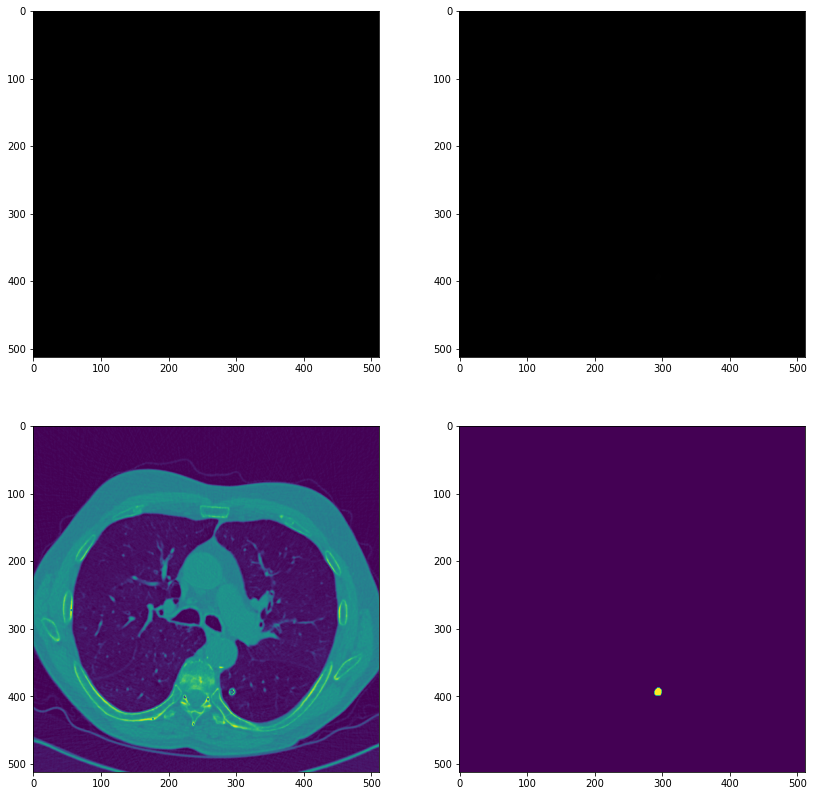

In [21]:
img = load_image('img_LIDC-IDRI-0648_496.npz', '/data/train/images/')
mask = load_mask('mask_LIDC-IDRI-0648_496.npz', '/data/train/masks/')
f, a = plt.subplots(2,2, figsize=(14,14))
a[0][0].imshow(img, cmap='Greys_r')
a[0][1].imshow(mask)

img = np.array(img)
mask = np.array(mask)
a[1][0].imshow(img)
a[1][1].imshow(mask)

In [27]:
# np.unique(np.array(arr))

In [28]:
# arr2 = np.array(arr)/255.0
# plt.imshow(arr2)

/tmp/ipykernel_406/3512977569.py:6: RuntimeWarning: divide by zero encountered in true_divide
  rescaled = (255.0 / img_data.max() * (img_data - img_data.min())).astype(np.uint8)/255.0
/tmp/ipykernel_406/3512977569.py:6: RuntimeWarning: invalid value encountered in multiply
  rescaled = (255.0 / img_data.max() * (img_data - img_data.min())).astype(np.uint8)/255.0


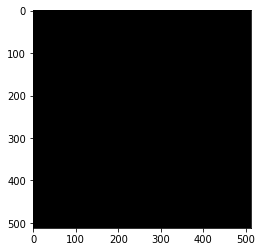

In [22]:
root_dir = '/data/all/train/masks/'
arr = load_image(train_mask_files[0], root_dir)
plt.imshow(arr)

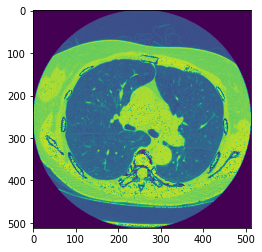

In [23]:
root_dir = '/data/all/train/images/'
arr = load_image(train_image_files[0], root_dir)
plt.imshow(np.array(arr))

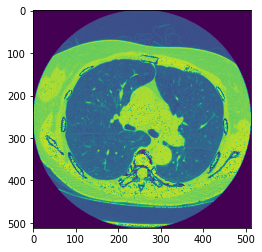

In [24]:
plt.imshow(np.array(arr))

In [25]:
np.unique(np.array(arr))

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

In [27]:
# from tensorflow import keras
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img


# class OxfordPets(keras.utils.Sequence):
#     """Helper to iterate over the data (as Numpy arrays)."""

#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     def __len__(self):
#         return len(self.target_img_paths) // self.batch_size

#     def __getitem__(self, idx):
#         """Returns tuple (input, target) correspond to batch #idx."""
#         i = idx * self.batch_size
#         batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
#         batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
#         x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
#         for j, path in enumerate(batch_input_img_paths):
#             #img = load_img(path, target_size=self.img_size, color_mode="grayscale")
#             img= load_image(path, '/data/train/images')
#             img = np.array(img)
#             img = np.expand_dims(img, -1)
#             #img = np.expand_dims(img/255.0, -1)
#             #x[j] = np.expand_dims(img, 2)
#             x[j] = img
#         y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
#         for j, path in enumerate(batch_target_img_paths):
#             #img = load_img(path, target_size=self.img_size, color_mode="grayscale")
#             msk = load_mask(path, '/data/train/masks')
#             msk = np.array(msk)
#             msk = np.expand_dims(msk, -1)
#             #msk = np.expand_dims(msk/255.0, -1)
#             #y[j] = np.expand_dims(img, 2)
#             y[j] = msk
#             # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
# #             y[j] -= 1
# #             y1 = y[j] < 1
# #             y[j] = y1.astype(int)
#         return x, y

In [26]:
batch_size = 24
img_size = (512, 512)

In [28]:
#ls /data/test/images

In [29]:
# # Instantiate data Sequences for each split
# train_gen = OxfordPets(batch_size, img_size, train_image_files, train_mask_files)
# val_gen = OxfordPets(batch_size, img_size, val_image_files, val_mask_files)

In [30]:
# val_image_files

In [31]:
# inp, tar = train_gen[0]

In [32]:
# tar[0]

In [23]:
def data_generator(image_files, mask_files, root_dir='/data/train/'):
    for image_path, mask_path in zip(image_files, mask_files):
        img = load_image(image_path, root_dir + '/images')
        img = np.array(img)
        img = np.expand_dims(img, -1)

        msk = load_mask(mask_path, root_dir + '/masks')
        msk = np.array(msk)
        msk = np.expand_dims(msk, -1)
        yield img, msk
#         try:
#             img = load_image(image_path, root_dir + '/images')
#             img = np.array(img)
#             img = np.expand_dims(img, -1)

#             msk = load_mask(mask_path, root_dir + '/masks')
#             msk = np.array(msk)
#             msk = np.expand_dims(msk, -1)

#             yield img, msk
#         except:
#             print("Error loading file {} and {}".format(image_path, mask_path))
#             continue

def get_dataset_from_directory(image_files, mask_files, root_dir):
    generator = lambda: data_generator(image_files, mask_files, root_dir)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32)))

In [24]:
ds_train = get_dataset_from_directory(train_image_files, train_mask_files, '/data/all/train')
ds_val = get_dataset_from_directory(val_image_files, val_mask_files, '/data/all/train')

In [25]:
#ls /data/all/train/images

In [26]:
for a, b in ds_train.take(9):
    print(b.shape)

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


In [44]:
np.unique(a)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

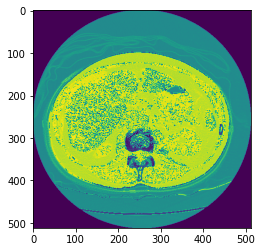

In [36]:
plt.imshow(np.array(a))

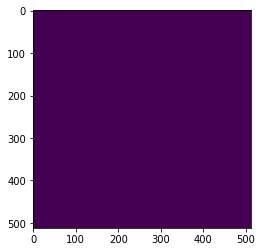

In [37]:
plt.imshow(np.array(b))

In [27]:
buffer_size = 167068 #size of the dataset
#For perfect shuffling, set the buffer size equal to the full size of the dataset. For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer.
# dataset_train = ds_train.shuffle(buffer_size).batch(24)
# dataset_val = ds_val.shuffle(buffer_size).batch(24)

dataset_train = ds_train.batch(24)
dataset_val = ds_val.batch(24)

# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset_train = dataset_train.with_options(options)
dataset_val = dataset_val.with_options(options)

In [112]:
# with mirrored_strategy.scope():
#     opt = keras.optimizers.Adam(learning_rate=1e-4)
# opt = keras.optimizers.Adam(learning_rate=1e-4)
# model.compile(optimizer=opt, loss=['binary_crossentropy'])#, metrics=[dice_coef])
callbacks = [
    keras.callbacks.ModelCheckpoint("model/lung_segmentation.h5", save_best_only=True)
]
epochs = 10
#history = model.fit_generator(my_generator , epochs=epochs,steps_per_epoch=300,validation_steps =50)
# history = model2.fit_generator(my_generator , epochs=epochs,steps_per_epoch=100, validation_data=val_generator,validation_steps =50)
#history = model.fit(train_gen , validation_data=val_gen, epochs=epochs,steps_per_epoch=300,validation_steps =50, callbacks=callbacks)
#history = model.fit(dataset_train , validation_data=dataset_val, epochs=epochs,steps_per_epoch=300,validation_steps =50, callbacks=callbacks)
history = model.fit(dataset_train , validation_data=dataset_val, epochs=epochs, callbacks=callbacks)

Epoch 1/10
   1393/Unknown - 594s 426ms/step - loss: 3.7919e-04 - dice_coef: nan   Dice coeff nan for Tensor("cond_4/Identity_1:0", shape=(None, 512, 512, 1), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Dice coeff nan for Tensor("cond_5/Identity_1:0", shape=(None, 512, 512, 1), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
Dice coeff nan for Tensor("cond_6/Identity_1:0", shape=(None, 512, 512, 1), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:2)
Dice coeff nan for Tensor("cond_7/Identity_1:0", shape=(None, 512, 512, 1), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:3)
1393/1393 [==============================] - 720s 517ms/step - loss: 3.7919e-04 - dice_coef: nan - val_loss: 5.0038e-04 - val_dice_coef: nan


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
1393/1393 [==============================] - 685s 492ms/step - loss: 3.8222e-04 - dice_coef: nan - val_loss: 4.1152e-04 - val_dice_coef: nan
Epoch 3/10
1393/1393 [==============================] - 685s 491ms/step - loss: 3.7588e-04 - dice_coef: nan - val_loss: 5.7803e-04 - val_dice_coef: nan
Epoch 4/10
1393/1393 [==============================] - 683s 490ms/step - loss: 3.8394e-04 - dice_coef: nan - val_loss: 4.7124e-04 - val_dice_coef: nan
Epoch 5/10
1393/1393 [==============================] - 687s 493ms/step - loss: 4.1906e-04 - dice_coef: nan - val_loss: 5.9318e-04 - val_dice_coef: nan
Epoch 6/10
1393/1393 [==============================] - 689s 495ms/step - loss: 7.6041e-04 - dice_coef: nan - val_loss: 0.0020 - val_dice_coef: nan
Epoch 7/10
1393/1393 [==============================] - 686s 493ms/step - loss: 0.0029 - dice_coef: nan - val_loss: 3.8146e-04 - val_dice_coef: nan
Epoch 8/10
 142/1393 [==>...........................] - ETA: 8:53 - loss: 0.0022 - dice_coef: 0.

KeyboardInterrupt: 

In [ ]:
x = np.arange(len(history.history['loss'])-1)
plt.plot(x, history.history['loss'][1:], label='loss')
plt.plot(x, history.history['val_loss'][1:], label='val_loss')

In [33]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

In [34]:
data_folder = '/data/downloaded_small_lidc_sorted/'
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [88]:
image = vol[:,:,k_slice]#.astype('float32')
rescaled_img = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
print(np.unique(rescaled_img))
rescaled_img = rescaled_img/255.0
print(np.unique(rescaled_img))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

#### Data preparation for training

In [90]:
np.unique(CT_mask)

array([0, 1], dtype=int16)

In [93]:
mask_data = CT_mask
mask_data = (255.0 / mask_data.max() * (mask_data - mask_data.min())).astype(np.uint8)
np.unique(mask_data/255.0)

array([0., 1.])

In [94]:
np.unique(vol[:,:,k_slice])

array([-2048, -1039, -1036, ...,  1382,  1387,  1388], dtype=int16)

The images loaded from the DICOM are unit16. These images are saved as .npz files for space savings. 
During training, we load the .npz files and perform transformations to map the values to 0-255 range for both the images and the masks.
Though we are rescaling the mask which is already values of either 0 or 1, to first 0 - 255 range of values, we would then convert them back to 0 and 1 by dividing the values with 255.0 once again. This step seems unnecessary and we may skip that.

In summary, we have an image of type uint16 with values ranging from -2048 to 2048, which we convert to unit8 with values ranging between 0 and 1.
We do this for both the image and the mask. But like I mentioned above, we may skip it for the mask since mask is already values of either 0 and 1.

When we predict, the predictions would be probabilities and we could either take argmax which would require a lengthy training to generate visually aligned predictions or we could simply plot / draw the pixel values as per the probabilities.

Note: if you use PIL Image load from array for an array with values between 0 and 1, you may not be able to display the image, but we do not care, because we would not need them for training.

In [24]:
!pip install pylidc

     |████████████████████████████████| 5.6 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 42.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 75.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 48.3 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 56.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 47.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 71.1 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 66.9 MB/s eta 0:00:01


In [113]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
#data_folder = os.getcwd() + '/cohort_sorted_3/'

In [114]:
# patient_list[0]

In [115]:
data_folder = '/data/downloaded_small_lidc_sorted/'
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [116]:
ls /data/downloaded_small_lidc_sorted/

LIDC-IDRI-0069/  LIDC-IDRI-0086/  LIDC-IDRI-0101/  LIDC-IDRI-0314/
LIDC-IDRI-0078/  LIDC-IDRI-0094/  LIDC-IDRI-0106/  LIDC-IDRI-0325/
LIDC-IDRI-0079/  LIDC-IDRI-0095/  LIDC-IDRI-0298/  LIDC-IDRI-0345/
LIDC-IDRI-0084/  LIDC-IDRI-0098/  LIDC-IDRI-0300/


In [39]:
model.predict(rescaled_img[np.newaxis,:,:, np.newaxis])

2021-10-06 13:06:15.880133: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_82354"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

array([[[[0.49999976],
         [0.49999976],
         [0.49999976],
         ...,
         [0.5000002 ],
         [0.5000002 ],
         [0.5000002 ]],

        [[0.49999976],
         [0.49999976],
         [0.49999976],
         ...,
         [0.5000002 ],
         [0.5000002 ],
         [0.5000002 ]],

        [[0.49999964],
         [0.49999964],
         [0.49999976],
         ...,
         [0.5000002 ],
         [0.5000002 ],
         [0.5000002 ]],

        ...,

        [[0.49999988],
         [0.49999988],
         [0.49999988],
         ...,
         [0.49999988],
         [0.49999988],
         [0.49999988]],

        [[0.49999988],
         [0.49999988],
         [0.5       ],
         ...,
         [0.49999988],
         [0.49999988],
         [0.49999988]],

        [[0.49999988],
         [0.49999988],
         [0.5       ],
         ...,
         [0.49999988],
         [0.49999988],
         [0.49999988]]]], dtype=float32)

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


2021-10-06 15:12:29.501629: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_202702"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

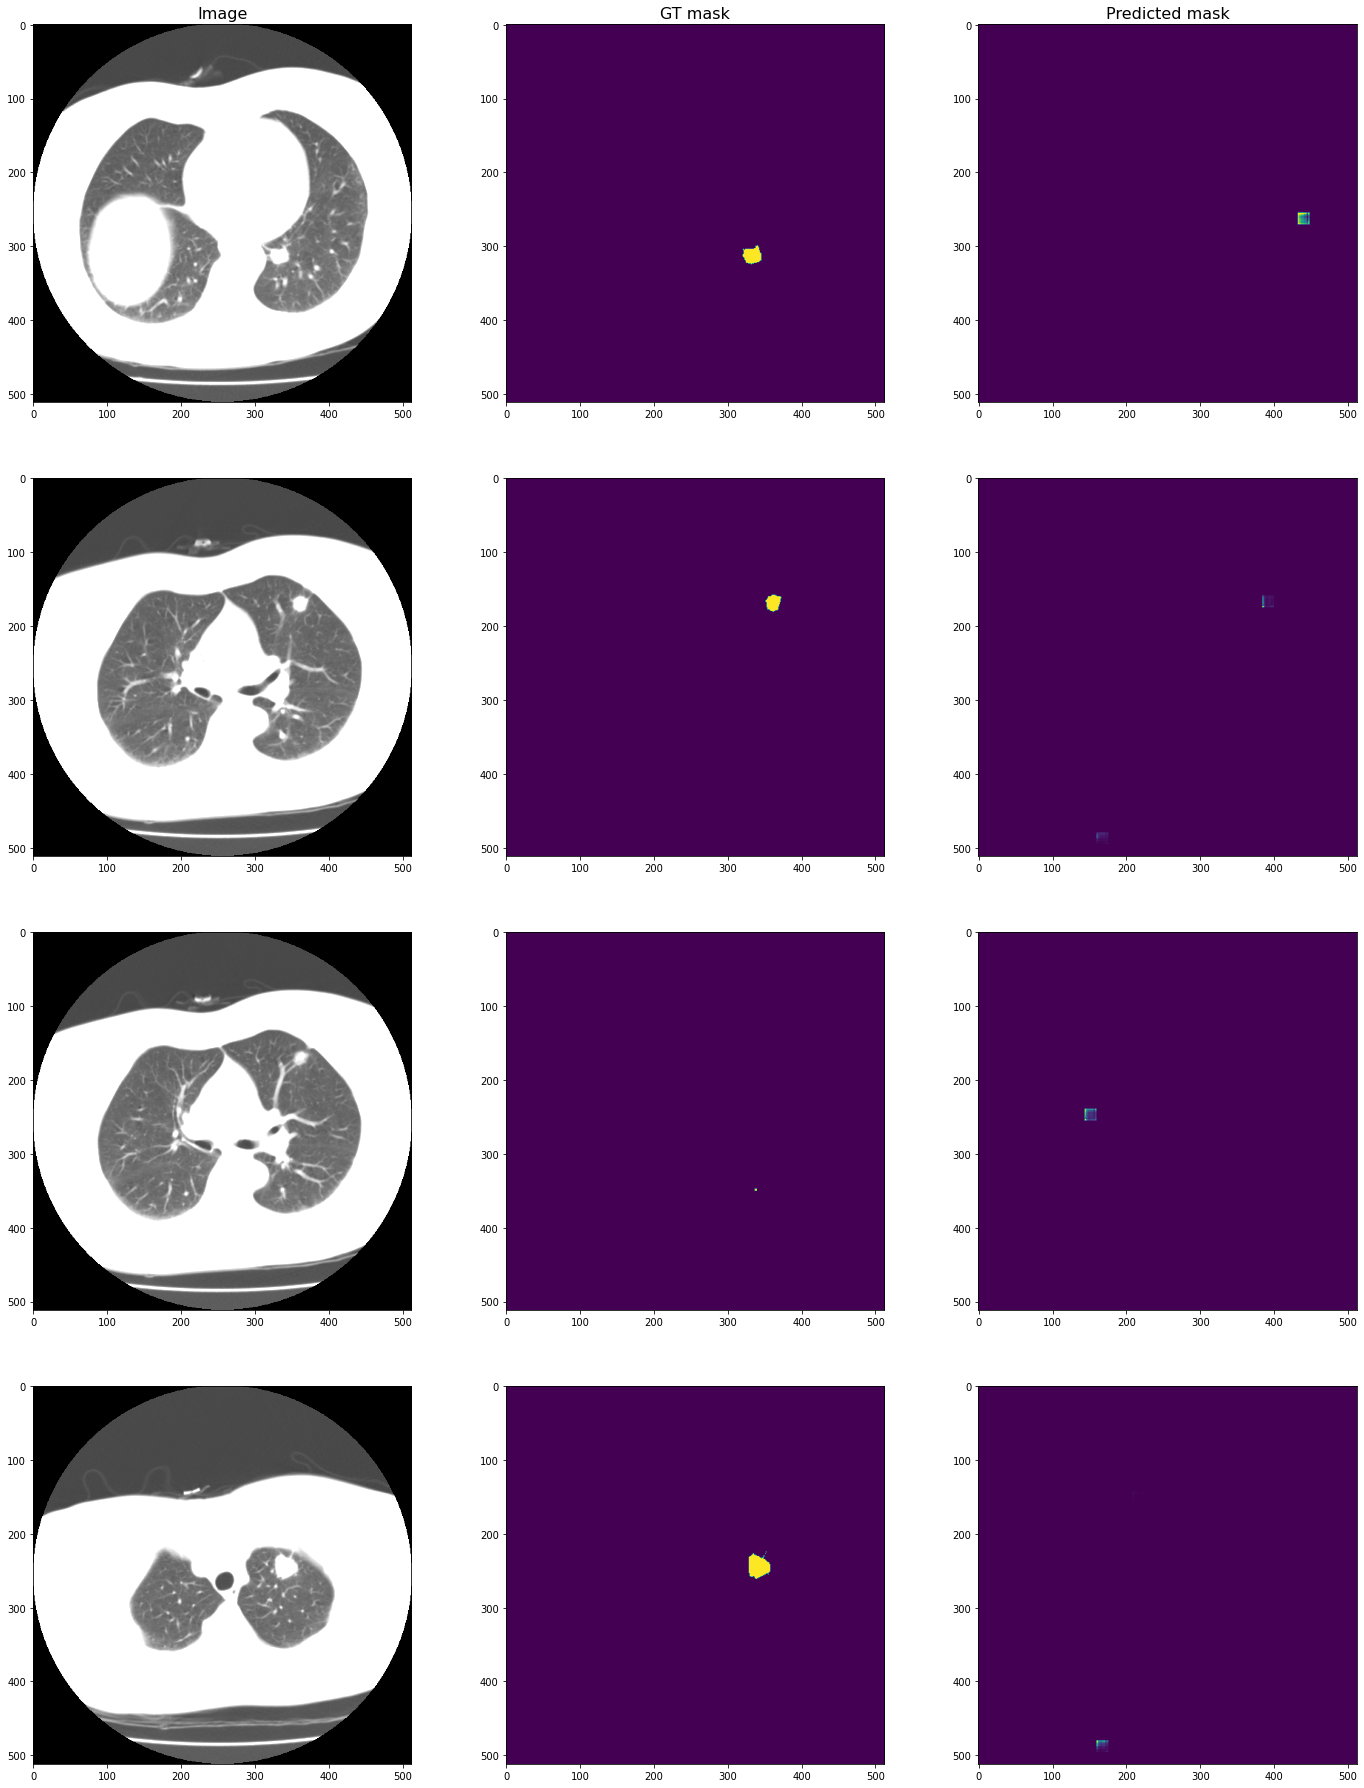

In [117]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    #vol is uint16
    image = vol[:,:,k_slice]#.astype('float32')
    #convert image to 0-255, integer size 8, unit8
    rescaled_img = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    #image = ((image - (image.min()+1)) * (1/((image.max() - image.min() + 1)) * 255)).astype('uint8')
    #image = image.astype('float32')/255.0
    #convert the image to value between 0 and 1
    rescaled_img = rescaled_img/255.0
#     image -= np.mean(image)
#     image /= np.std(image)
#     image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
#     mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = model.predict(rescaled_img[np.newaxis,:,:, np.newaxis])
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    #mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)

In [68]:
ls /data/temp/sorted_gcsfiles/

### JAKE UNET

In [119]:
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-n1k89krd
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-n1k89krd
  Resolved https://github.com/jakeret/unet.git to commit f557a51b6f95aae6848cab6141e6cae573934bf8
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25690 sha256=32e8fc4fba7d1402fe03c6d1c767a6075d36b57892a74d503dbb932aba682b7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-64g41xy8/wheels/6f/2d/a5/25ff85a8501ea97085319f56dae96e4fe1a9161df3a6a12499
Successfully built unet


In [1]:
import unet
from unet.datasets import circles

2021-10-06 15:15:58.479965: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [2]:
LEARNING_RATE = 1e-3
unet_model = unet.build_model(channels=circles.channels,
                              num_classes=circles.classes,
                              layer_depth=3,
                              filters_root=64)
unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

2021-10-06 15:16:12.688264: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-10-06 15:16:15.381338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 15:16:15.382386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-10-06 15:16:15.382606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-06 15:16:15.383468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 1 with properties: 
pciBusID: 0000:00:05.0 na

In [5]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

In [3]:
train_dataset, validation_dataset = circles.load_data(100, nx=172, ny=172, splits=(0.8, 0.2))

In [29]:
train_dataset.element_spec

(TensorSpec(shape=(172, 172, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(172, 172, 2), dtype=tf.float64, name=None))

In [28]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)
trainer.fit(unet_model,dataset_train,
            dataset_val,
            epochs=10,
            batch_size=1)

ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/unet/unet.py:44 call  *
        x = self.conv2d_1(x)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, None, 512, 512)
